In [ ]:
from __future__ import annotations

from typing import Union, Optional

import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('/home/inca/default.mplstyle')

from astropy import units as u
from astropy import constants as const

import LWphotorates as lwrad

In [ ]:
class Spectrum:

    def __init__(
            self: Spectrum,
            frequency: Optional[Union[np.array, u.Quantity]] = None,
            energy: Optional[Union[np.array, u.Quantity]] = None,
            wavelength: Optional[Union[np.array, u.Quantity]] = None,
            intensity_frequency: Optional[Union[np.array, u.Quantity]] = None,
            intensity_wavelength: Optional[Union[np.array, u.Quantity]] = None) -> None:

        if not (frequency is not None) | (energy is not None) | (wavelength is not None):
            raise AssertionError("Provide at least one between frequency, energy and wavelength.")
        if not (intensity_frequency is not None) | (intensity_wavelength is not None):
            raise AssertionError("Provide the spectrum either in the frequency or wavelength space.")

        if frequency is not None:
            if not isinstance(frequency, u.Quantity):
                frequency *= u.Hz
            else:
                frequency = frequency.to(u.Hz)
            self.frequency = frequency
            self.wavelength = lwrad.utils.nu2lambda(self.frequency)
            self.energy = self.frequency * const.h.to(u.eV / u.Hz)
        elif energy is not None:
            if not isinstance(energy, u.Quantity):
                energy *= u.eV
            else:
                energy = energy.to(u.eV)
            self.energy = energy
            self.frequency = self.energy / const.h.to(u.eV / u.Hz)
            self.wavelength = lwrad.utils.nu2lambda(self.frequency)
        elif wavelength is not None:
            if not isinstance(wavelength, u.Quantity):
                wavelength *= u.angstrom
            else:
                wavelength = wavelength.to(u.angstrom)
            self.wavelength = wavelength
            self.frequency = lwrad.utils.lambda2nu(self.wavelength)
            self.energy = self.frequency * const.h.to(u.eV / u.Hz)

        if intensity_frequency is not None:
            monocromatic_intensity_unit = u.erg / u.s / u.Hz / u.sr / u.cm**2
            if not isinstance(intensity_frequency, u.Quantity):
                intensity_frequency *= monocromatic_intensity_unit
            else:
                intensity_frequency = intensity_frequency.to(monocromatic_intensity_unit)
            self.spectrum_frequency = intensity_frequency
            self.spectrum_wavelength = lwrad.utils.spec_nu2lambda(self.frequency, self.spectrum_frequency)
        elif intensity_wavelength is not None:
            monocromatic_intensity_unit = u.erg / u.s / u.angstrom / u.sr / u.cm**2
            if not isinstance(intensity_frequency, u.Quantity):
                intensity_wavelength *= monocromatic_intensity_unit
            else:
                intensity_wavelength = intensity_wavelength.to(monocromatic_intensity_unit)
            self.spectrum_wavelength = intensity_wavelength
            self.intensity_frequency = lwrad.utils.spec_lambda2nu(self.wavelength, self.spectrum_wavelength)


In [ ]:
default_gas_density = 1e0 * u.cm**-3
default_gas_temperature = 1e2 * u.K
default_distance = np.sqrt(1. / 4. / np.pi) * u.cm
solid_angle = 4. * np.pi * u.sr
conv_fact_intensity_to_luminosity = solid_angle * u.cm**2

h2_min_gspop = 1e-5
h2_min_foscxfdiss = 1e-6

In [ ]:
energy_array = np.linspace(lwrad.HM.get_reaction_min_energy(), lwrad.HM.get_ioniz_energy_hydrogen(), 10000)
flat_spectrum = Spectrum(
    energy=energy_array,
    intensity_frequency=lwrad.utils.generate_flat_spectrum(len(energy_array))
)
radiation_temperature_array = np.logspace(3.7, 5, 20) * u.K
blackbody_spectra = Spectrum(
    energy=energy_array,
    intensity_frequency=[lwrad.utils.generate_blackbody_spectrum(
        radtemp, energy_array, True, lwrad.HM.get_ioniz_energy_hydrogen()) for radtemp in radiation_temperature_array]
)
for spec in [flat_spectrum, blackbody_spectra]:
    spec.spectrum_frequency *= 1e-21
    spec.spectrum_wavelength *= 1e-21

In [ ]:
h2rate_flatspec = lwrad.compute_H2_diss_rate(
    wavelength_array=flat_spectrum.wavelength,
    spectra_wl=flat_spectrum.spectrum_wavelength*conv_fact_intensity_to_luminosity,
    distance=default_distance,
    gas_density=default_gas_density,
    gas_temperature=default_gas_temperature,
    min_partition_function=h2_min_gspop,
    min_osc_strength_x_diss_fraction=h2_min_foscxfdiss)

/home/inca/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/inca/miniconda3/lib/python3.8/site-packages/frigus/solvers/linear.py:48: LinAlgWarning: Ill-conditioned matrix (rcond=9.93892e-27): result may not be accurate.
  C21 = scipy.linalg.solve(A22, A21)


In [ ]:
h2rate_bbspec = lwrad.compute_H2_diss_rate(
    wavelength_array=blackbody_spectra.wavelength,
    spectra_wl=blackbody_spectra.spectrum_wavelength*conv_fact_intensity_to_luminosity,
    distance=default_distance,
    gas_density=default_gas_density,
    gas_temperature=default_gas_temperature,
    min_partition_function=h2_min_gspop,
    min_osc_strength_x_diss_fraction=h2_min_foscxfdiss)

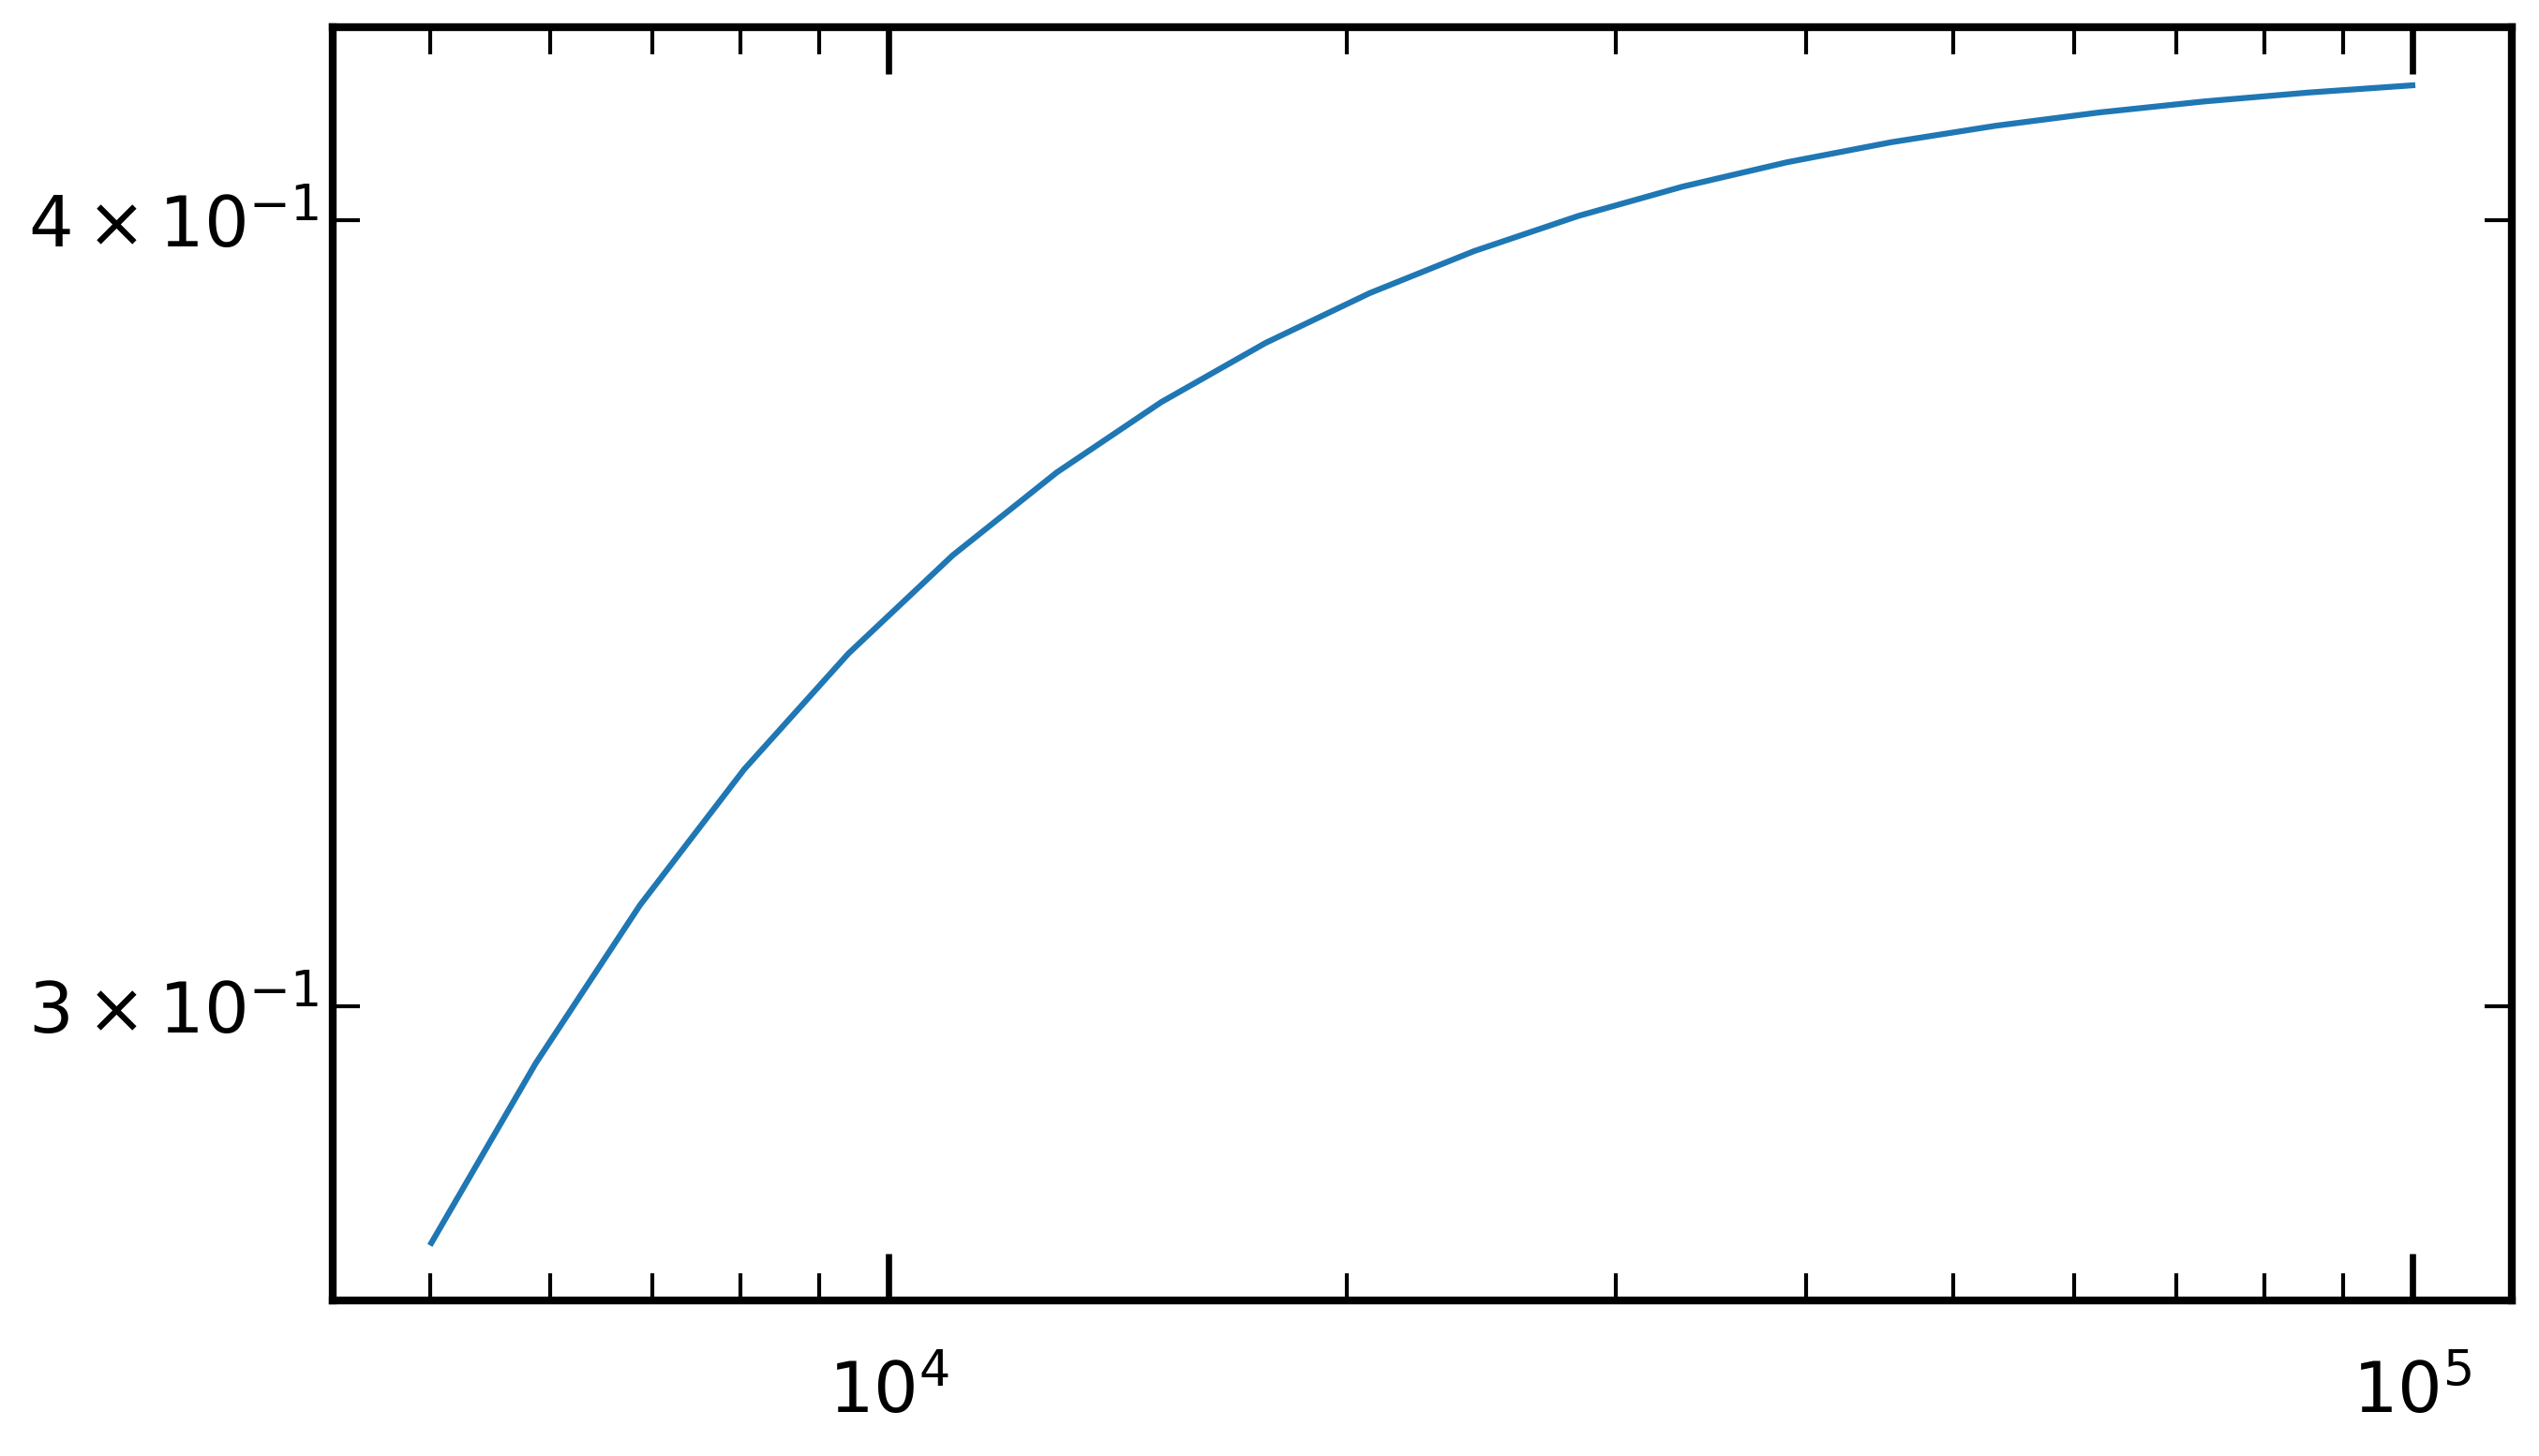

In [ ]:
fig, ax = plt.subplots()
ax.plot(radiation_temperature_array, h2rate_bbspec[1] / h2rate_bbspec[0])
ax.set_yscale('log')
ax.set_xscale('log')